In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_score, accuracy_score, roc_curve
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the dataset
data = pd.read_csv('Dataset (1).csv')

In [3]:
# Initial exploration
print("Shape of dataset:", data.shape)
print("Columns in dataset:", data.columns)
print("Data types:\n", data.dtypes)
print("\nSample data:\n", data.head())


Shape of dataset: (91713, 186)
Columns in dataset: Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)
Data types:
 encounter_id                     int64
patient_id                       int64
hospital_id                      int64
hospital_death                   int64
age                            float64
                                ...   
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Length: 186, dtype: object

Sample data:
    encounter_id  patient_id  hospital_id  hospital_death   age 

In [4]:
# Check for missing values
print("\nMissing values per column:\n", data.isnull().sum())


Missing values per column:
 encounter_id                      0
patient_id                        0
hospital_id                       0
hospital_death                    0
age                            4228
                               ... 
leukemia                        715
lymphoma                        715
solid_tumor_with_metastasis     715
apache_3j_bodysystem           1662
apache_2_bodysystem            1662
Length: 186, dtype: int64


In [5]:
# Basic statistics
print("\nBasic statistics:\n", data.describe())


Basic statistics:
         encounter_id     patient_id   hospital_id  hospital_death  \
count   91713.000000   91713.000000  91713.000000    91713.000000   
mean    65606.079280   65537.131464    105.669262        0.086302   
std     37795.088538   37811.252183     62.854406        0.280811   
min         1.000000       1.000000      2.000000        0.000000   
25%     32852.000000   32830.000000     47.000000        0.000000   
50%     65665.000000   65413.000000    109.000000        0.000000   
75%     98342.000000   98298.000000    161.000000        0.000000   
max    131051.000000  131051.000000    204.000000        1.000000   

                age           bmi  elective_surgery        height  \
count  87485.000000  88284.000000      91713.000000  90379.000000   
mean      62.309516     29.185818          0.183736    169.641588   
std       16.775119      8.275142          0.387271     10.795378   
min       16.000000     14.844926          0.000000    137.200000   
25%       52.

In [9]:
# Remove duplicate records
data = data.drop_duplicates()
print("Shape after removing duplicates:", data.shape)


Shape after removing duplicates: (91713, 186)


In [6]:
# Impute missing values
# Numeric columns: Median
numeric_cols = data.select_dtypes(include=np.number).columns
numeric_imputer = SimpleImputer(strategy='median')
data[numeric_cols] = numeric_imputer.fit_transform(data[numeric_cols])

In [7]:
# Categorical columns: Most frequent
categorical_cols = data.select_dtypes(include='object').columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

In [8]:
print("\nMissing values after imputation:\n", data.isnull().sum())


Missing values after imputation:
 encounter_id                   0
patient_id                     0
hospital_id                    0
hospital_death                 0
age                            0
                              ..
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
apache_2_bodysystem            0
Length: 186, dtype: int64


In [9]:
# Prior visits (Example logic based on available columns)
data['prior_visits'] = data.groupby('patient_id')['encounter_id'].transform('count')

In [10]:
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Changed sparse=False to sparse_output=False
encoded_data = encoder.fit_transform(data[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))
data = pd.concat([data, encoded_df], axis=1).drop(columns=categorical_cols)

In [11]:
print("\nFeature engineering complete. New shape:", data.shape)


Feature engineering complete. New shape: (91713, 239)


In [12]:
#MODEL DEVELOPMENT

In [13]:
# Split data
X = data.drop(columns=['hospital_death'])  # Replace with target column
# Convert the target variable to binary (0 or 1) if it's continuous.
y = (data['hospital_death'] > 0).astype(int) #Values greater than 0 will be 1, else 0


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
log_reg = LogisticRegression(random_state=56)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("\nLogistic Regression Metrics:\n", classification_report(y_test, y_pred_log))


Logistic Regression Metrics:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     16760
           1       0.70      0.30      0.42      1583

    accuracy                           0.93     18343
   macro avg       0.82      0.64      0.69     18343
weighted avg       0.92      0.93      0.92     18343



In [17]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Metrics:\n", classification_report(y_test, y_pred_rf))


Random Forest Metrics:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     16760
           1       0.74      0.29      0.42      1583

    accuracy                           0.93     18343
   macro avg       0.84      0.64      0.69     18343
weighted avg       0.92      0.93      0.92     18343



In [69]:
# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("\nGradient Boosting Metrics:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Metrics:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     16760
           1       0.70      0.33      0.45      1583

    accuracy                           0.93     18343
   macro avg       0.82      0.66      0.71     18343
weighted avg       0.92      0.93      0.92     18343



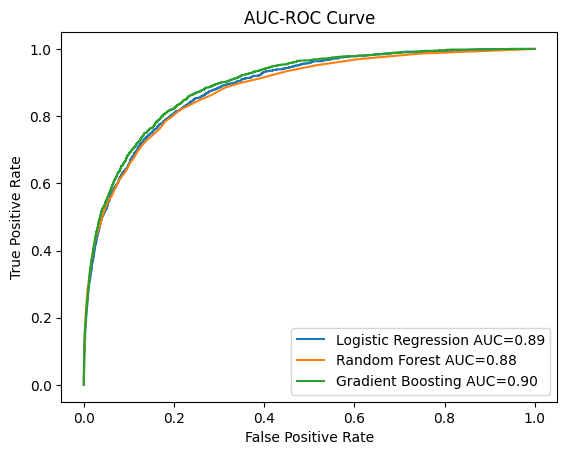

In [41]:
# AUC-ROC Curve for each model
models = {'Logistic Regression': log_reg, 'Random Forest': rf, 'Gradient Boosting': gb}
for model_name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} AUC={auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('AUC-ROC Curve')
plt.show()

 97%|=================== | 17770/18343 [00:26<00:00]       

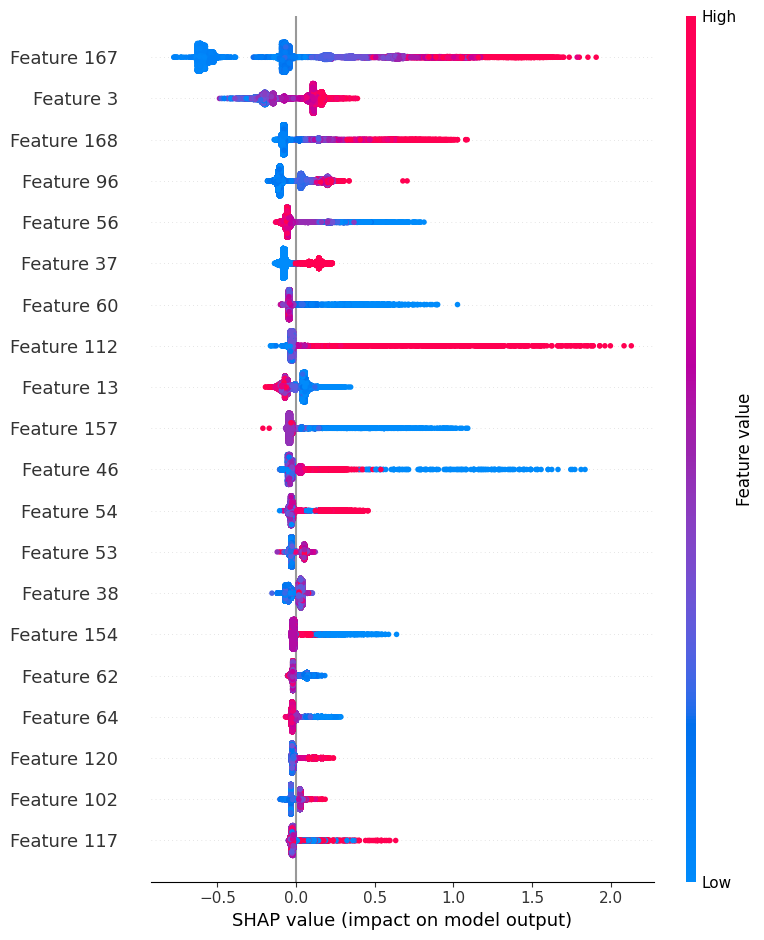

In [42]:
# SHAP for Gradient Boosting
explainer = shap.Explainer(gb, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

In [19]:
from xgboost import XGBClassifier

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=56)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=56, ...)

In [20]:
##Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}
grid = GridSearchCV(RandomForestClassifier(random_state=56), param_grid, scoring='recall', cv=5)
grid.fit(X_train, y_train)
print("Best Parameters for Recall:", grid.best_params_)


Best Parameters for Recall: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train with best parameters
rf_best = RandomForestClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_split=2,
    n_estimators=200,
    random_state=56
)
rf_best.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_best.predict(X_test)
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

# Evaluate model
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_rf))



Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92     16760
           1       0.35      0.70      0.47      1583

    accuracy                           0.86     18343
   macro avg       0.66      0.79      0.70     18343
weighted avg       0.92      0.86      0.88     18343

AUC-ROC: 0.8898193364160072


In [22]:
optimal_threshold = 0.4  # Example threshold
y_pred_rf_tuned = (y_proba_rf >= optimal_threshold).astype(int)

print("\nClassification Report with Tuned Threshold:\n", classification_report(y_test, y_pred_rf_tuned))



Classification Report with Tuned Threshold:
               precision    recall  f1-score   support

           0       0.98      0.80      0.88     16760
           1       0.27      0.80      0.41      1583

    accuracy                           0.80     18343
   macro avg       0.63      0.80      0.64     18343
weighted avg       0.92      0.80      0.84     18343



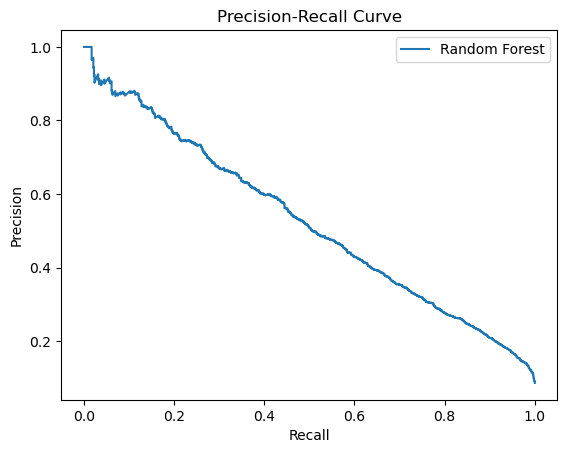

Optimal Threshold: 0.05340221942028513

Classification Report with Optimized Threshold:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     16760
           1       0.09      1.00      0.16      1583

    accuracy                           0.09     18343
   macro avg       0.04      0.50      0.08     18343
weighted avg       0.01      0.09      0.01     18343



In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
plt.plot(recall, precision, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Choose a threshold balancing precision and recall
optimal_idx = np.argmax(recall - precision)  # Example: Maximize (Recall - Precision)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# Predict with the new threshold
y_pred_rf_optimized = (y_proba_rf >= optimal_threshold).astype(int)
print("\nClassification Report with Optimized Threshold:\n", classification_report(y_test, y_pred_rf_optimized))


In [77]:
##Decent score##
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('rf', rf_best),
    ('xgb', XGBClassifier(scale_pos_weight=10, random_state=56))
], voting='soft')  # Use soft voting for probabilities

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
y_proba_ensemble = ensemble.predict_proba(X_test)[:, 1]

print("\nEnsemble Classification Report:\n", classification_report(y_test, y_pred_ensemble))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_ensemble))



Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93     16760
           1       0.40      0.70      0.51      1583

    accuracy                           0.88     18343
   macro avg       0.68      0.80      0.72     18343
weighted avg       0.92      0.88      0.90     18343

AUC-ROC: 0.9008114256939408


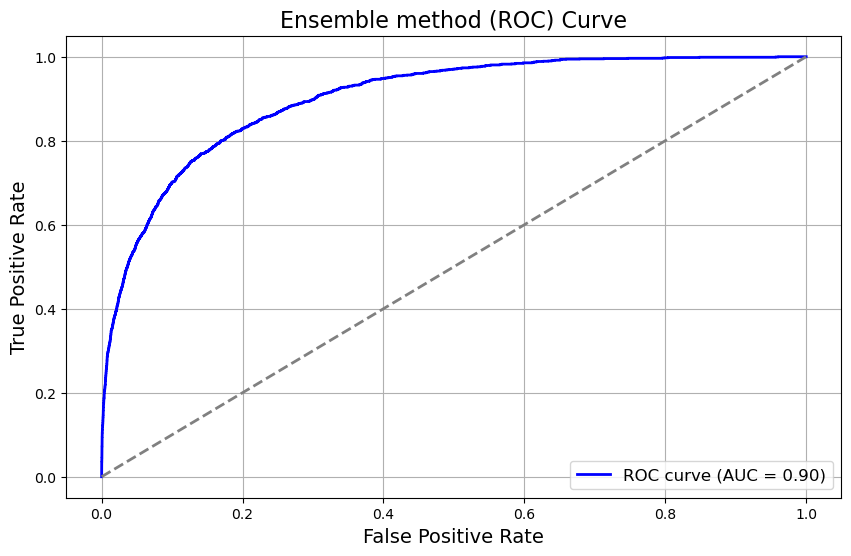

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_proba_ensemble)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Ensemble method (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()


In [67]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# Define the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_best),  # Random Forest
    ('xgb', XGBClassifier(scale_pos_weight=10, random_state=56))  # XGBoost
], voting='soft')  # Soft voting for probabilities

# Perform Cross-Validation
cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='roc_auc')  # Use your preferred scoring metric

print("Cross-Validation AUC-ROC Scores:", cv_scores)
print("Mean AUC-ROC:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())


Cross-Validation AUC-ROC Scores: [0.88989002 0.89383127 0.88708976 0.88887038 0.89595217]
Mean AUC-ROC: 0.8911267219840824
Standard Deviation: 0.00327160908969293


In [68]:
# Retrain the VotingClassifier on the full training data
voting_clf.fit(X_train, y_train)

# Evaluate on the test set
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.93     16760
           1       0.37      0.73      0.49      1583

    accuracy                           0.87     18343
   macro avg       0.67      0.81      0.71     18343
weighted avg       0.92      0.87      0.89     18343

AUC-ROC: 0.8986888585010486


In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define individual models with tuned parameters
rf_best = RandomForestClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_split=2,
    n_estimators=200,
    random_state=56
)

xgb_best = XGBClassifier(
    scale_pos_weight=10,  # Adjusted for imbalance
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    random_state=56
)

# Define Voting Classifier
ensemble = VotingClassifier(estimators=[
    ('rf', rf_best),
    ('xgb', xgb_best)
], voting='soft')

# Perform cross-validation
cv_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation AUC-ROC Scores:", cv_scores)
print("Mean AUC-ROC:", np.mean(cv_scores))


Cross-Validation AUC-ROC Scores: [0.89371622 0.89908909 0.89277287 0.89516397 0.89659268]
Mean AUC-ROC: 0.8954669641784905


In [71]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define individual models with tuned parameters
rf_best = RandomForestClassifier(
    class_weight='balanced',
    max_depth=10,
    min_samples_split=2,
    n_estimators=200,
    random_state=56
)

xgb_best = XGBClassifier(
    scale_pos_weight=10,  # Adjusted for imbalance
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    random_state=56
)

# Define Voting Classifier
ensemble = VotingClassifier(estimators=[
    ('rf', rf_best),
    ('xgb', xgb_best)
], voting='soft')

# Perform cross-validation
cv_scores = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation AUC-ROC Scores:", cv_scores)
print("Mean AUC-ROC:", np.mean(cv_scores))


Cross-Validation AUC-ROC Scores: [0.89371622 0.89908909 0.89277287 0.89516397 0.89659268]
Mean AUC-ROC: 0.8954669641784905


In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize Decision Tree
dt = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=10,  # Limit depth to prevent overfitting
    random_state=42
)

# Cross-validate
cv_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='roc_auc')
print("Decision Tree Cross-Validation AUC-ROC Scores:", cv_scores)
print("Mean AUC-ROC:", np.mean(cv_scores))

# Train on the full dataset
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

# Evaluate
from sklearn.metrics import classification_report, roc_auc_score
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_dt))


Decision Tree Cross-Validation AUC-ROC Scores: [0.78239575 0.79759785 0.7741962  0.78266675 0.76607344]
Mean AUC-ROC: 0.7805859962095558

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.88     16760
           1       0.27      0.70      0.38      1583

    accuracy                           0.81     18343
   macro avg       0.62      0.76      0.63     18343
weighted avg       0.91      0.81      0.84     18343

AUC-ROC: 0.7995747817276946


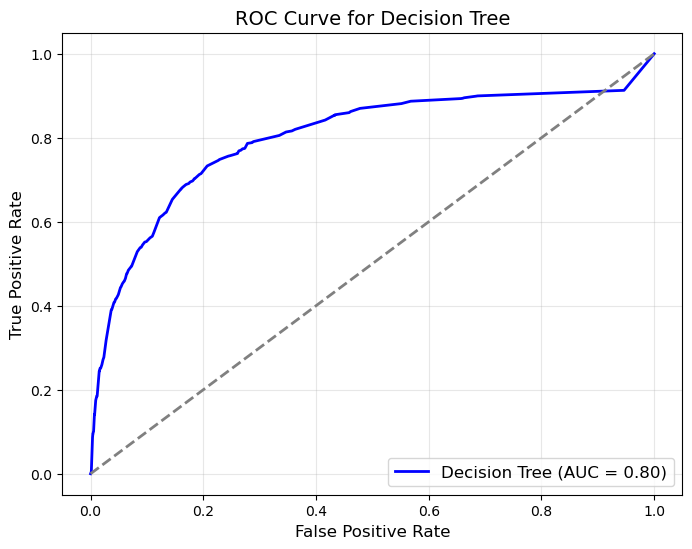

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_proba_dt are available
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"Decision Tree (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for Decision Tree", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [82]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Initialize Naive Bayes
nb = GaussianNB()

# Cross-validate
cv_scores = cross_val_score(nb, X_train, y_train, cv=5, scoring='roc_auc')
print("Naive Bayes Cross-Validation AUC-ROC Scores:", cv_scores)
print("Mean AUC-ROC:", np.mean(cv_scores))

# Train on the full dataset
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
y_proba_nb = nb.predict_proba(X_test)[:, 1]

# Evaluate
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))
print("AUC-ROC:", roc_auc_score(y_test, y_proba_nb))


Naive Bayes Cross-Validation AUC-ROC Scores: [0.81569761 0.8231722  0.82340239 0.81214071 0.81160265]
Mean AUC-ROC: 0.8172031131806939

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88     16760
           1       0.25      0.67      0.37      1583

    accuracy                           0.80     18343
   macro avg       0.61      0.74      0.62     18343
weighted avg       0.90      0.80      0.84     18343

AUC-ROC: 0.8211807246444547


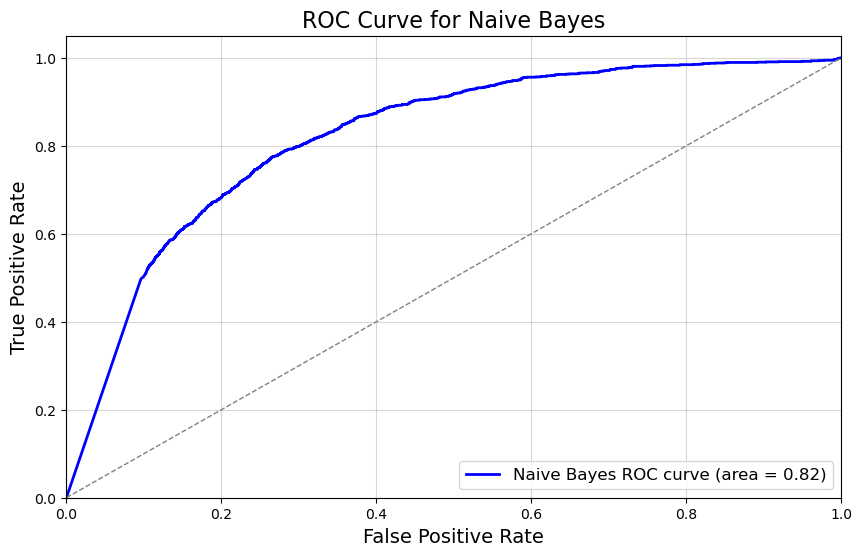

In [80]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_proba_nb are available from the Naive Bayes model execution

# Compute ROC curve and ROC area
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Plot ROC curve for Naive Bayes
plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label=f'Naive Bayes ROC curve (area = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Naive Bayes', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.5)
plt.show()


In [ ]:
##################TESTING#########################################################